In [ ]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # use gpu

In [ ]:
# loading data
usc_raw_data = pd.read_csv('/content/drive/MyDrive/Industrial Team Project/USCHAD_rawdata.csv')

In [ ]:
# only features and label.
usc_unprocessed = usc_raw_data[['acc_x','acc_y','acc_z','gyro_x','gyro_y','gyro_z','label']]

In [ ]:
usc_unprocessed.head(5)

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z,label
0,0.977355,0.125578,-0.072511,-1.934198,4.831090,-3.059582,7
1,0.980789,0.125578,-0.072511,-1.128533,4.806113,-2.639555,7
2,0.980789,0.121959,-0.068851,-1.128533,3.979873,-2.222339,7
3,0.980789,0.121959,-0.072511,-0.725701,2.757195,-3.008654,7
4,0.980789,0.121959,-0.068851,-1.118572,2.743157,-2.989551,7


In [ ]:
# window_size: size of time window
# step: overlapping
# data: dataset
def time_windows(window_size,overlapping,data):
  sigmentation_data_temp = []
  sigmentation_data = []
  sigmentation_label = []
  for i in range(0,len(data),overlapping):
    acc_x = data['acc_x'].values[i:i+window_size]
    acc_y = data['acc_y'].values[i:i+window_size]
    acc_z = data['acc_z'].values[i:i+window_size]
    gyro_x = data['gyro_x'].values[i:i+window_size]
    gyro_y = data['gyro_y'].values[i:i+window_size]
    gyro_z = data['gyro_z'].values[i:i+window_size]
    total_label = data['label'].values[i:i+window_size]
    label = Counter(total_label).most_common()[0][0]
    sigmentation_data_temp.append([acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z])
    sigmentation_arr = np.asarray(sigmentation_data_temp)
    sig_size = sigmentation_arr.shape
    if sig_size[2] == window_size:
      sigmentation_arr.reshape(window_size,6)
      sigmentation_data.append(sigmentation_arr)
      sigmentation_label.append(label)
      sigmentation_data_temp = []
    else:
      sigmentation_data_temp = []

  sigmentation_data_arr = np.asarray(sigmentation_data)
  sigmentation_label_arr = np.asarray(sigmentation_label)

  return sigmentation_data_arr,sigmentation_label_arr


In [ ]:
# here use semi-non-overlapping
# signal segmentation and relevant labels
uci_readings,uci_labels = time_windows(128,64,usc_unprocessed)

In [ ]:
# in the model, requires 0-n label so make labels from 1-12 into 0-11
uci_labels = uci_labels-1

In [ ]:
print('Shape of data:')
print(uci_readings.shape)
print('#######################')
print('Shape of labels: ')
print(uci_labels.shape)

Shape of data:
(43894, 1, 6, 128)
#######################
Shape of labels: 
(43894,)


In [ ]:
# use train_test_split to generate train,val and test data
x_train,x_val_test,y_train,y_val_test = train_test_split(uci_readings,uci_labels,test_size = 0.3)
x_val,x_test,y_val,y_test = train_test_split(x_val_test,y_val_test,test_size = 0.3 )

In [ ]:
# use torch.TensorDataset to make dataset
train_dataset = TensorDataset(torch.from_numpy(x_train).to(torch.float32),torch.from_numpy(y_train).to(torch.float32))
val_dataset = TensorDataset(torch.from_numpy(x_val).to(torch.float32),torch.from_numpy(y_val).to(torch.float32))
test_dataset = TensorDataset(torch.from_numpy(x_test).to(torch.float32),torch.from_numpy(y_test).to(torch.float32))

In [ ]:
# DataLoader generation
train_loader = data.DataLoader(dataset = train_dataset,batch_size = 64,shuffle = True)
val_loader = data.DataLoader(dataset = val_dataset,batch_size = 64,shuffle = True)
test_loader = data.DataLoader(dataset = test_dataset,batch_size = 64,shuffle = False)

## 50% overlapping

In [ ]:
 # now define a class of CNN model
class CNN_50(nn.Module):
  def __init__(self):
    super(CNN_50, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2))
    self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
    )
    # self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(3072, 512)
    self.fc3 = nn.Linear(512,12)
  def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc3(out)
        return out
        
model_50 = CNN_50().to(device)

In [ ]:
# hyperparameters
epoches = 50
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_50.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [ ]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader:
        imgs = imgs.reshape(len(imgs),1,32,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_50(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  49.3246541903987  % Loss:  1.4272949007841258
Epoch:  2 accuracy:  63.44344995931652  % Loss:  1.0286866220763715
Epoch:  3 accuracy:  69.71847030105776  % Loss:  0.8498693025533474
Epoch:  4 accuracy:  76.40358014646054  % Loss:  0.6725571656177545
Epoch:  5 accuracy:  80.33523189585028  % Loss:  0.5431646777165903
Epoch:  6 accuracy:  81.89096826688365  % Loss:  0.4929561317896397
Epoch:  7 accuracy:  82.64605370219691  % Loss:  0.4649370574467891
Epoch:  8 accuracy:  83.32628152969895  % Loss:  0.44421599204351897
Epoch:  9 accuracy:  83.38161106590724  % Loss:  0.43703675867985786
Epoch:  10 accuracy:  83.9446704637917  % Loss:  0.4133855026532855
Epoch:  11 accuracy:  84.68348250610252  % Loss:  0.3976733262908186
Epoch:  12 accuracy:  84.92432872253865  % Loss:  0.38875234474015585
Epoch:  13 accuracy:  85.23677786818551  % Loss:  0.37542441087676187
Epoch:  14 accuracy:  85.73148901545973  % Loss:  0.36316662868814015
Epoch:  15 accuracy:  85.97233523189585 

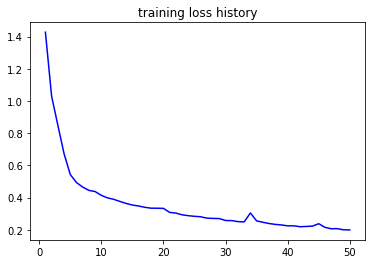

In [ ]:
import matplotlib.pyplot as plt
x = []
for i in range(1,51):
  x.append(i)
y = loss_list
fig = plt.figure()
plt.plot(x,y,color = 'blue')
plt.title('training loss history')
plt.show()

In [ ]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_50(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('Test accuracy is: ',test_accuracy)

Test accuracy is:  86.45912427233611


#0 overlapping

2layers 3x3 : 73% |||
2layers 5x5 : 74.9% |||
3layers 3x3 : 83.5 |||
3layers 5x5 : 85.1 |||

final decision : 3layers 5x5


## 2layers

In [ ]:
uci_readings_non_overlapping,uci_labels_non_overlapping = time_windows(128,128,usc_unprocessed)

In [ ]:
uci_labels_non_overlapping = uci_labels_non_overlapping - 1

In [ ]:
x_train_non_overlapping,x_val_test_non_overlapping,y_train_non_overlapping,y_val_test_non_overlapping = train_test_split(uci_readings_non_overlapping,uci_labels_non_overlapping,test_size = 0.3)
x_val_non_overlapping,x_test_non_overlapping,y_val_non_overlapping,y_test_non_overlapping = train_test_split(x_val_test_non_overlapping,y_val_test_non_overlapping,test_size = 0.3 )

In [ ]:
train_dataset_non_overlapping = TensorDataset(torch.from_numpy(x_train_non_overlapping).to(torch.float32),torch.from_numpy(y_train_non_overlapping).to(torch.float32))
val_dataset_non_overlapping = TensorDataset(torch.from_numpy(x_val_non_overlapping).to(torch.float32),torch.from_numpy(y_val_non_overlapping).to(torch.float32))
test_dataset_non_overlapping = TensorDataset(torch.from_numpy(x_test_non_overlapping).to(torch.float32),torch.from_numpy(y_test_non_overlapping).to(torch.float32))

In [ ]:
# DataLoader generation
train_loader_non_overlapping = data.DataLoader(dataset = train_dataset_non_overlapping,batch_size = 64,shuffle = True)
val_loader_non_overlapping = data.DataLoader(dataset = val_dataset_non_overlapping,batch_size = 64,shuffle = True)
test_loader_non_overlapping = data.DataLoader(dataset = test_dataset_non_overlapping,batch_size = 64,shuffle = False)

In [ ]:
 # now define a class of CNN model
class CNN_non_overlapping_2layers(nn.Module):
  def __init__(self):
    super(CNN_non_overlapping_2layers, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2))
    # self.layer2 = nn.Sequential(
    #         nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=2),
    #         nn.ReLU(),
    #         nn.BatchNorm2d(32),
    #         nn.MaxPool2d(2,2))
    self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
    )
    # self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(12288, 512)
    self.fc3 = nn.Linear(512,12)
  def forward(self, x):
        out = self.layer1(x)
        # out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        # out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc3(out)
        return out
        
model_non_overlapping_2layers = CNN_non_overlapping_2layers().to(device)

In [ ]:
epoches = 50
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_non_overlapping_2layers.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [ ]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_non_overlapping:
        imgs = imgs.reshape(len(imgs),1,32,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_non_overlapping_2layers(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  44.49290456971748  % Loss:  1.532622358611016
Epoch:  2 accuracy:  55.46152844681682  % Loss:  1.2222759787967097
Epoch:  3 accuracy:  59.35425074860044  % Loss:  1.1497134464904974
Epoch:  4 accuracy:  63.14281994531962  % Loss:  1.0748642057304065
Epoch:  5 accuracy:  65.39513084233823  % Loss:  1.0042939665901216
Epoch:  6 accuracy:  67.26337716443172  % Loss:  0.9441210165063375
Epoch:  7 accuracy:  69.16417133185783  % Loss:  0.8760925682253857
Epoch:  8 accuracy:  71.46204921234214  % Loss:  0.8120593271562173
Epoch:  9 accuracy:  73.91615675042313  % Loss:  0.750220776840859
Epoch:  10 accuracy:  76.07733368051035  % Loss:  0.6994513294261521
Epoch:  11 accuracy:  77.95859914073688  % Loss:  0.6439038765659223
Epoch:  12 accuracy:  79.38419476630646  % Loss:  0.6052083572164116
Epoch:  13 accuracy:  79.5534435620362  % Loss:  0.5908498487037247
Epoch:  14 accuracy:  81.31753677906522  % Loss:  0.5494866228944533
Epoch:  15 accuracy:  81.61046738705897  % Los

In [ ]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_non_overlapping:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_non_overlapping_2layers(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('Test accuracy is: ',test_accuracy)

Test accuracy is:  74.9493927125506


## 3layers

## 4 Layers(not expected, marked)

In [ ]:
 # now define a class of CNN model
class CNN_non_overlapping_4layers(nn.Module):
  def __init__(self):
    super(CNN_non_overlapping_4layers, self).__init__()
    self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
             nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
             nn.ReLU(),
             nn.BatchNorm2d(32),
             nn.MaxPool2d(2,2))
    self.layer3 = nn.Sequential(
             nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
             nn.ReLU(),
             nn.BatchNorm2d(64),
             nn.MaxPool2d(2,2))
    self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.ReLU()
    )
    self.drop_out = nn.Dropout()
    self.fc1 = nn.Linear(1536, 512)
    self.fc3 = nn.Linear(512,12)
  def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc3(out)
        return out
        
model_non_overlapping_4layers = CNN_non_overlapping_4layers().to(device)

In [ ]:
epoches = 50
lr = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_non_overlapping_4layers.parameters(),lr=lr, weight_decay=0.0001,momentum = 0.8)

In [ ]:
# training
loss_list = []
for epoch in range(epoches):
    acc = 0
    correct = 0
    total = 0
    loss_num = 0
    runtime_loss = 0
    for (imgs,labels) in train_loader_non_overlapping:
        imgs = imgs.reshape(len(imgs),1,32,24)     
        imgs = imgs.to(device)
        labels = labels.type(torch.LongTensor)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model_non_overlapping_4layers(imgs)
        loss = criterion(outputs, labels)
        runtime_loss += loss.item()
        loss.backward()
        optimizer.step()
        total += labels.size(0)
        _,predicted = torch.max(outputs.data,1)
        correct += (predicted == labels).sum().item()
        loss_num+=1
    acc = 100 * correct / total
    epoch_loss = runtime_loss / loss_num
    loss_list.append(epoch_loss)
    loss_num = 0
    print("Epoch: ",epoch+1, "accuracy: ", acc,' %',"Loss: ",epoch_loss)

Epoch:  1 accuracy:  39.35685457622705  % Loss:  1.7711191053707076
Epoch:  2 accuracy:  52.92279651087098  % Loss:  1.258254825821556
Epoch:  3 accuracy:  61.150891810962115  % Loss:  1.0869571675403484
Epoch:  4 accuracy:  67.95990105455019  % Loss:  0.9131546539884385
Epoch:  5 accuracy:  75.08787918239813  % Loss:  0.7195416513320322
Epoch:  6 accuracy:  77.8218981903398  % Loss:  0.6305727336663923
Epoch:  7 accuracy:  79.37117562817342  % Loss:  0.5635268778474499
Epoch:  8 accuracy:  80.92696263507356  % Loss:  0.5099657576732121
Epoch:  9 accuracy:  81.96198411665148  % Loss:  0.48496404216002625
Epoch:  10 accuracy:  82.87332378596537  % Loss:  0.4620056444183919
Epoch:  11 accuracy:  83.74560604088009  % Loss:  0.42970076945312785
Epoch:  12 accuracy:  83.95391225100899  % Loss:  0.4124357416545702
Epoch:  13 accuracy:  84.36401510220024  % Loss:  0.4001222814189819
Epoch:  14 accuracy:  84.93685718005469  % Loss:  0.381699328105974
Epoch:  15 accuracy:  85.27535477151413  % 

In [ ]:
# test
correct_test = 0

total_test = 0

with torch.no_grad():

  for (imgs_test,labels_test) in test_loader_non_overlapping:

    imgs_test = imgs_test.reshape(len(imgs_test),1,32,24)

    imgs_test = imgs_test.to(device)

    labels_test = labels_test.type(torch.LongTensor)

    labels_test = labels_test.to(device)

    outputs_test = model_non_overlapping_4layers(imgs_test)

    labels_test = labels_test.reshape(labels_test.shape[0],)

    predicted_test = torch.max(outputs_test.data,1)[1]
      
    total_test += labels_test.size(0)
      
    correct_test += (predicted_test == labels_test).sum().item()

    test_accuracy = 100*correct_test/total_test

print('Test accuracy is: ',test_accuracy)

Test accuracy is:  82.99595141700405
